In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataloader
import seq2seq
from seq2seq.models import AttentionSeq2Seq, SimpleSeq2Seq, Seq2Seq
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.utils import np_utils
from keras.layers import CuDNNLSTM, LSTM, LeakyReLU, CuDNNGRU
from keras.layers.normalization import BatchNormalization
import keras.backend as K
%matplotlib notebook

input_seq_length = 288
output_seq_length = 48
dataloader.INPUT_SEQ_LENGTH = input_seq_length
dataloader.OUTPUT_SEQ_LENGTH = output_seq_length
X_train, Y_train, X_test, Y_test = dataloader.generate_data_keras(input_seq_length, output_seq_length)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
in_dim = X_train.shape[2] # 17
in_len = X_train.shape[1] # 288
out_dim = Y_train.shape[2] # 1
out_len = Y_train.shape[1] # 48
units = 256
second_units = 96
batch_size = 512
epochs = 10

print(in_dim, in_len, out_dim, out_len, batch_size, epochs)

Y_train = Y_train.reshape(-1, out_len)
Y_test = Y_test.reshape(-1, out_len)


(45433, 288, 17) (45433, 48, 1)
(1718, 288, 17) (1718, 48, 1)
17 288 1 48 512 10


In [91]:
def custom_mse(y_true, y_pred):
    scale_ = dataloader.scaler.scale_[0]
    min_ = dataloader.scaler.min_[0]
    y_pred -= min_
    y_true -= min_
    y_pred /= scale_
    y_true -= scale_
    #dataloader.denormalize_1d(y_true, dataloader.scaler.min_[0], dataloader.scaler.scale_[0])
    #dataloader.denormalize_1d(y_pred, dataloader.scaler.min_[0], dataloader.scaler.scale_[0])
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [4]:
#model 1
model = Sequential()
model.add(CuDNNGRU(units=units, input_shape=(in_len,in_dim), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(out_len))
model.add(Activation('tanh'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 256)               211200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                12336     
_________________________________________________________________
activation_1 (Activation)    (None, 48)                0         
Total params: 223,536
Trainable params: 223,536
Non-trainable params: 0
_________________________________________________________________


In [5]:
#model 2
model = Sequential()
model.add(CuDNNLSTM(units=units, input_shape=(in_len,in_dim), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(CuDNNLSTM(units=second_units, return_sequences=True))
model.add(Dropout(0.3))
model.add(CuDNNLSTM(units=second_units, return_sequences=False))
model.add(Dropout(0.3))
#model.add(Flatten())
model.add(Dense(out_len))
#model.add(LeakyReLU())
model.add(Activation('tanh'))
#model.add(BatchNormalization())
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_4 (CuDNNLSTM)     (None, 288, 128)          75264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 288, 128)          512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 288, 128)          0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 288, 96)           86784     
_________________________________________________________________
dropout_5 (Dropout)          (None, 288, 96)           0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 96)                74496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 96)                0         
__________

In [3]:
output_file_name = 'nn_models/keras/attentionseq2seq'
model.fit(
    X_train, 
    Y_train, 
    batch_size=batch_size,
    validation_split=0.2,
    #validation_data=(validation_datas,validation_labels), 
    epochs=epochs,
    verbose=1)

Train on 36346 samples, validate on 9087 samples
Epoch 1/10
36346/36346 [==============================] - 30s 828us/step - loss: 0.0019 - val_loss: 0.0152
Epoch 2/10
36346/36346 [==============================] - 31s 855us/step - loss: 2.8839e-04 - val_loss: 0.0084
Epoch 3/10
36346/36346 [==============================] - 32s 887us/step - loss: 1.7527e-04 - val_loss: 0.0071
Epoch 4/10
36346/36346 [==============================] - 32s 890us/step - loss: 1.3017e-04 - val_loss: 0.0071
Epoch 5/10
36346/36346 [==============================] - 36s 984us/step - loss: 1.0392e-04 - val_loss: 0.0046
Epoch 6/10
36346/36346 [==============================] - 36s 996us/step - loss: 8.9947e-05 - val_loss: 0.0057
Epoch 7/10
36346/36346 [==============================] - 36s 997us/step - loss: 7.9359e-05 - val_loss: 0.0054
Epoch 8/10
36346/36346 [==============================] - 36s 991us/step - loss: 6.8021e-05 - val_loss: 0.0052
Epoch 9/10
36346/36346 [==============================] - 36s 995us

Let's visualize 5 predictions with our signals:
(5, 288, 17) (5, 48, 1)
5/5 [==============================] - 3s 653ms/step
outputs_shape (5, 48)


<IPython.core.display.Javascript object>


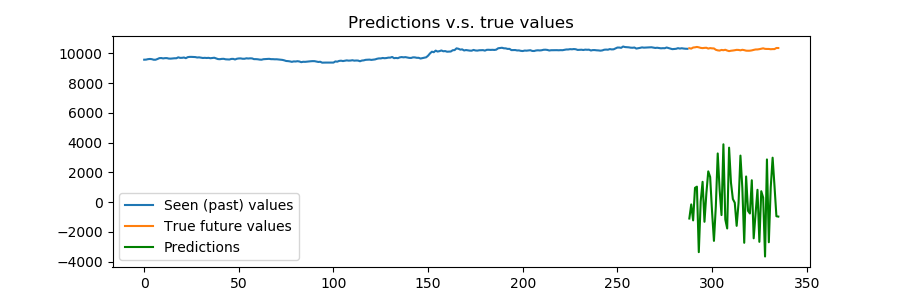

Test mse is:  107298991.69727701
(288,) (48,) (48,)


<IPython.core.display.Javascript object>


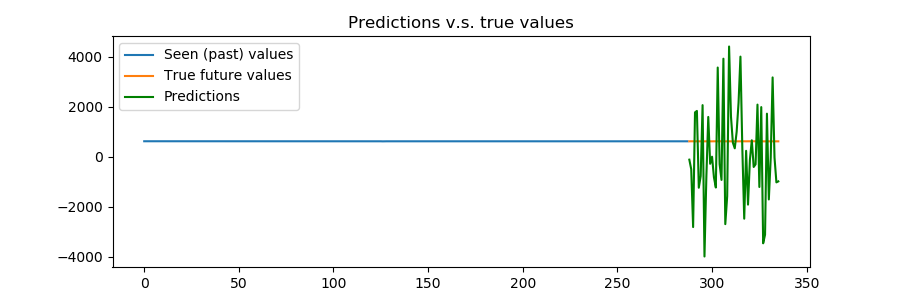

Test mse is:  4129706.858836949
(288,) (48,) (48,)


<IPython.core.display.Javascript object>


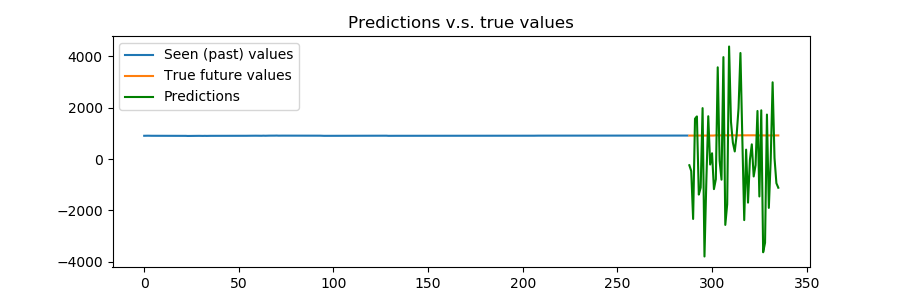

Test mse is:  4466427.456998588
(288,) (48,) (48,)


<IPython.core.display.Javascript object>


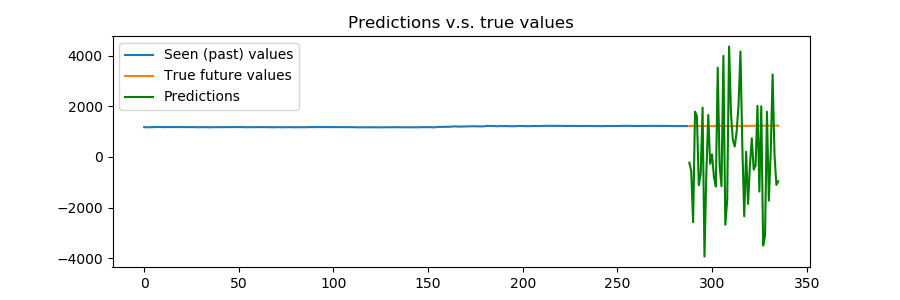

Test mse is:  5116319.295715508
(288,) (48,) (48,)


<IPython.core.display.Javascript object>


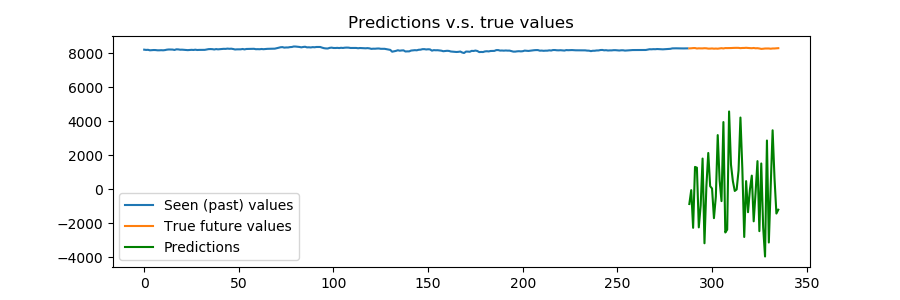

Test mse is:  72548995.21227023
(288,) (48,) (48,)


In [5]:
# Test
nb_predictions = 5
print("Let's visualize {} predictions with our signals:".format(nb_predictions))
X, Y = dataloader.generate_data_keras_batch(isTrain=True, batch_size=nb_predictions)
print(X.shape, Y.shape)
#outputs = model.predict(X.reshape(-1,288,17), batch_size=5, verbose=1)
outputs = model.predict(X, batch_size=1, verbose=1)
#outputs = outputs.reshape(48,-1,1)
#feed_dict = {enc_inp[t]: X[t] for t in range(input_seq_length)}
#outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
print('outputs_shape', outputs.shape)


for j in range(nb_predictions): 
    plt.figure(figsize=(9, 3))
    
    for k in range(out_dim):
        past = X[j,:,k]
        expected = Y[j,:,k]
        #pred = outputs[j,:,k]
        pred = outputs[j,:]
        
        dataloader.denormalize_1d(past, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        dataloader.denormalize_1d(expected, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        dataloader.denormalize_1d(pred, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        
        print("Test mse is: ", np.mean((pred - expected)**2))
        
        print(past.shape, expected.shape, pred.shape)
        #print(pred)
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "g", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()


In [7]:
total_mse = []
correct = []
sign = []

In [8]:
# Test
nb_predictions = 500
#nb_predictions = X_test.shape[0]
X, Y = dataloader.generate_data_keras_batch(isTrain=False, batch_size=nb_predictions)
#X = X_test
#Y = Y_test[:,None,:]
outputs = model.predict(X, batch_size=32, verbose=0)


for j in range(nb_predictions): 
    for k in range(out_dim):
        past = X[j,:,k]
        expected = Y[j,:,k]
        #pred = outputs[j,:,k]
        pred = outputs[j,:]
        dataloader.denormalize_1d(past, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        dataloader.denormalize_1d(expected, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        dataloader.denormalize_1d(pred, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        mse = np.mean((pred - expected)**2)
        
        prediction_sign = np.sign(pred[-1] - past[-1])
        
        if np.sign(expected[-1]-past[-1]) == np.sign(pred[-1] - past[-1]):
            correct.append(1)
        else:
            correct.append(0)
            
            
        sign.append(prediction_sign)
        total_mse.append(mse)
        #print(past.shape, expected.shape, pred.shape)

print('Average MSE:', np.mean(total_mse))    
print('Percent of successful predictions:', np.mean(correct))
print('Average sign of predictions::', np.mean(sign))

Average MSE: 82876781.13547085
Percent of successful predictions: 0.522
Average sign of predictions:: -1.0


In [41]:
c = [1,2,3,4]
c[-1]

4